# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense,GRU

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [1]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/traffic-dataset
License(s): unknown
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 106MB/s]
Archive:  traffic-dataset.zip
  inflating: Traffic Data.csv        


In [42]:
df = pd.read_csv('/content/Traffic Data.csv',index_col=['date_time'],parse_dates=['date_time'])
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2017-08-27 01:00:00,1209.0,291.15,0.0,0.0,90,Mist,mist
2018-09-06 23:00:00,1248.0,286.01,0.0,0.0,1,Clear,sky is clear
2017-08-25 18:00:00,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds
2017-11-09 22:00:00,2838.0,262.35,0.0,0.0,1,Clear,sky is clear
2017-11-09 15:00:00,5794.0,267.08,0.0,0.0,5,Clear,sky is clear


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

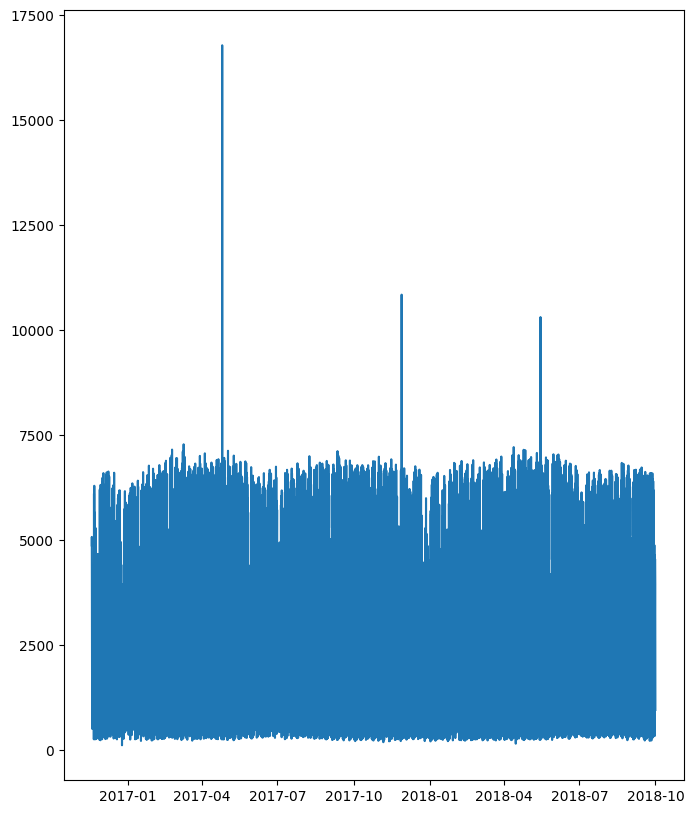

In [93]:
plt.figure(figsize=	(8,10))
plt.plot(df['traffic_volume'])

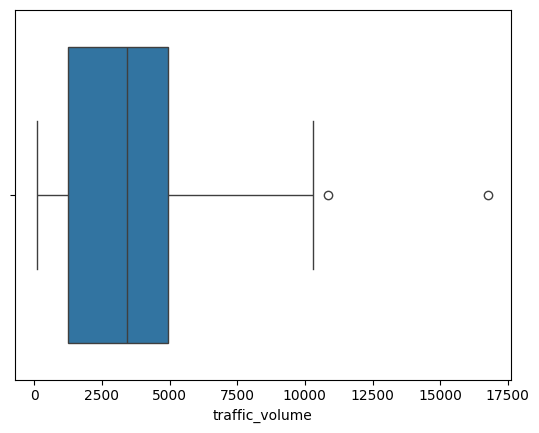

In [77]:
sns.boxplot(x=df['traffic_volume'])
plt.show()

In [130]:
result = seasonal_decompose(df['traffic_volume'], model='additive', period=364)

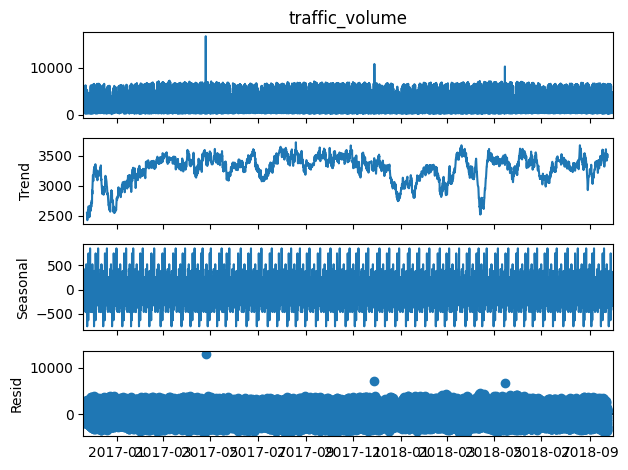

In [133]:
result.plot()
plt.show()

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  object 
 6   weather_description  20000 non-null  object 
 7   date_time            20000 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 1.2+ MB


In [22]:
df.isna().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
date_time,0


In [25]:
df['traffic_volume'].value_counts()

,count
traffic_volume,
353.0,29
340.0,22
358.0,22
373.0,22
344.0,22
...,...
1144.0,1
6245.0,1
1521.0,1


In [43]:
df['traffic_volume'] = df['traffic_volume'].fillna(df['traffic_volume'].mean())

In [27]:
df.isna().sum()

,0
traffic_volume,0
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
date_time,0


In [23]:
df.duplicated().sum()

12

In [44]:
df.drop_duplicates(inplace=True)

In [46]:
#Sort the dates
df = df.sort_index()
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Snow,heavy snow
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Mist,mist
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Fog,fog
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Fog,fog
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Mist,mist


In [50]:
label_encoder = LabelEncoder()
df['weather_main'] = label_encoder.fit_transform(df['weather_main'])
df['weather_description'] = label_encoder.fit_transform(df['weather_description'])

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [88]:
#Shift 3 was based on the data, it records 3 time every hour so with shift 3 you will get the value of the previous hour.
df['prev_traffic_volume'] = df['traffic_volume'].shift(3)

In [89]:
df['prev_traffic_volume'].isnull().sum()

3

In [91]:
df['prev_traffic_volume']= df['prev_traffic_volume'].fillna(df['prev_traffic_volume'].mean())
df.head(10)

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,prev_traffic_volume
date_time,,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,8,9,3278.414522
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,5,16,3278.414522
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,3,4,3278.414522
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,3,4,4872.000000
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,5,16,4872.000000
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,8,9,4872.000000
2016-11-18 17:00:00,4328.0,273.62,0.0,0.0,90,8,9,5074.000000
2016-11-18 17:00:00,4328.0,273.62,0.0,0.0,90,5,16,5074.000000
2016-11-18 17:00:00,4328.0,273.62,0.0,0.0,90,3,4,5074.000000


In [96]:
df['Day_of_the_week'] = df.index.dayofweek
df['month'] = df.index.month
df['day_of_the_year'] = df.index.dayofyear
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,prev_traffic_volume,Day_of_the_week,month,day_of_the_year
date_time,,,,,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,8,9,3278.414522,4,11,323
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,5,16,3278.414522,4,11,323
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,3,4,3278.414522,4,11,323
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,3,4,4872.000000,4,11,323
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,5,16,4872.000000,4,11,323


## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [97]:
train_split = int(len(df) * 0.8)
train_data = df[:train_split]
test_data = df[train_split:]

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [98]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.fit_transform(test_data)

In [53]:
def create_dataset(dataset, time_step):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0:dataset.shape[1]]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [116]:
X_train, Y_train = create_dataset(train_data_scaled, 10)
X_test, Y_test = create_dataset(test_data_scaled, 10)

In [100]:
X_test.shape

(3986, 10, 11)

In [101]:
X_train.shape

(15974, 10, 11)

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [117]:
model = Sequential()
model.add(LSTM(128, activation='relu',return_sequences=True, input_shape=(10, 11)))
model.add(LSTM(128, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [109]:
model = Sequential()
model.add(GRU(128, activation='relu',return_sequences=True, input_shape=(10, 11)))
model.add(GRU(128, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [118]:
history = model.fit(X_train, Y_train, epochs=50, batch_size=32,validation_data=(X_test,Y_test))

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.3275 - val_loss: 0.0990
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0758 - val_loss: 0.0623
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0631 - val_loss: 0.0670
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0628 - val_loss: 0.0586
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0522 - val_loss: 0.0570
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0479 - val_loss: 0.0578
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0474 - val_loss: 0.0545
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0549 - val_loss: 0.0501
Epoch 9/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0444 - val_loss: 0.0506
Epoch 10/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0508 - val_loss: 0.0466
Epoch 11/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0481 - val_loss: 0.0511
Epoch 12/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [119]:
predictions = model.predict(X_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [120]:
print('MAE:', mean_absolute_error(Y_test, predictions))

MAE: 0.1567815140507594


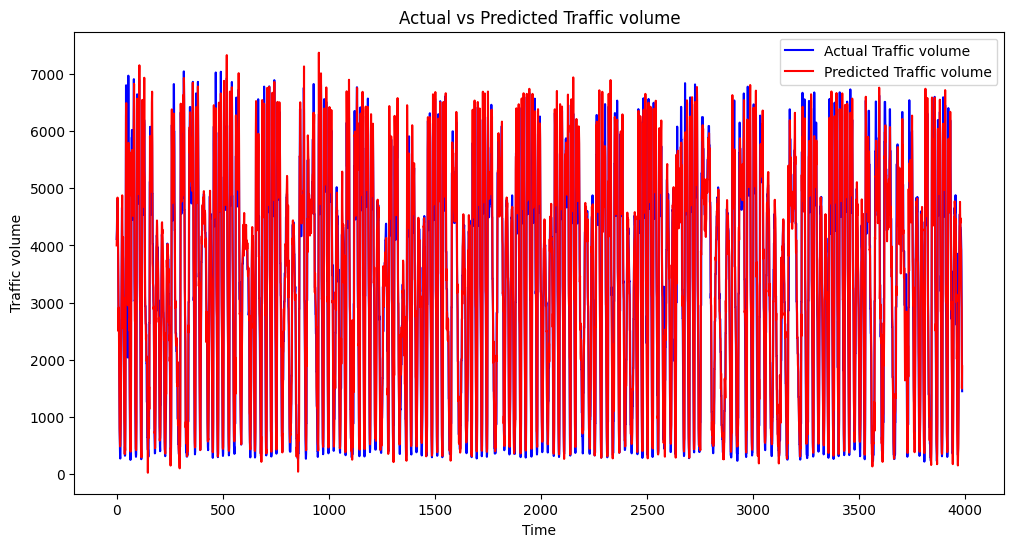

In [106]:
#Here we must inverse the the predection with number of features - 1, so we can plot the results clearly
predictions_rescaled = scaler.inverse_transform(np.concatenate((predictions,np.zeros((predictions.shape[0], 10))), axis=1))[:, 0]
Y_test_rescaled = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1),np.zeros((Y_test.shape[0], 10))), axis=1))[:, 0]

plt.figure(figsize=(12,6))
plt.plot(Y_test_rescaled, label='Actual Traffic volume', color='blue')
plt.plot(predictions_rescaled, label='Predicted Traffic volume', color='red')
plt.title('Actual vs Predicted Traffic volume')
plt.xlabel('Time')
plt.ylabel('Traffic volume')
plt.legend()
plt.show()

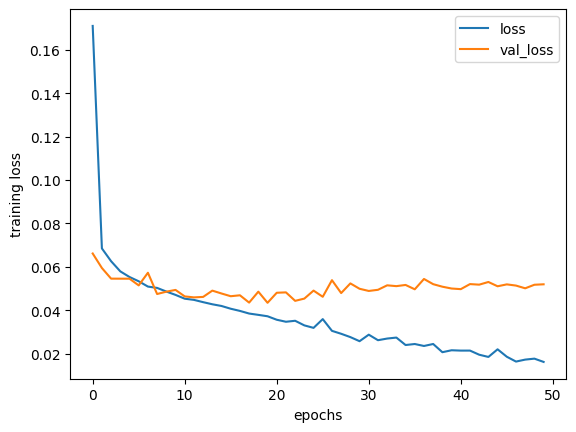

In [107]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.legend()
plt.show()

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [110]:
history = model.fit(X_train, Y_train, epochs=50, batch_size=32,validation_data=(X_test,Y_test))

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.2191 - val_loss: 0.0762
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0645 - val_loss: 0.0673
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0553 - val_loss: 0.0644
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0538 - val_loss: 0.0669
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0483 - val_loss: 0.0549
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0543 - val_loss: 0.0508
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0476 - val_loss: 0.0523
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0405 - val_loss: 0.0494
Epoch 9/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0409 - val_loss: 0.0543
Epoch 10/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0406 - val_loss: 0.0493
Epoch 11/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0401 - val_loss: 0.0498
Epoch 12/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/s

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [111]:
predictions = model.predict(X_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [115]:
print('MAE:', mean_absolute_error(Y_test, predictions))

MAE: 0.16130505060603165


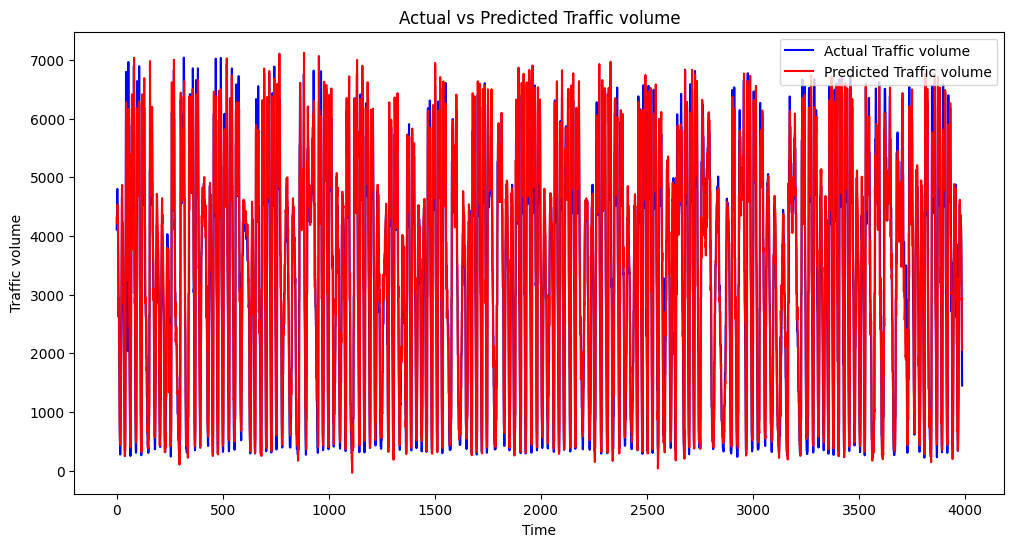

In [113]:
#Here we must inverse the the predection with number of features - 1, so we can plot the results clearly
predictions_rescaled = scaler.inverse_transform(np.concatenate((predictions,np.zeros((predictions.shape[0], 10))), axis=1))[:, 0]
Y_test_rescaled = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1),np.zeros((Y_test.shape[0], 10))), axis=1))[:, 0]

plt.figure(figsize=(12,6))
plt.plot(Y_test_rescaled, label='Actual Traffic volume', color='blue')
plt.plot(predictions_rescaled, label='Predicted Traffic volume', color='red')
plt.title('Actual vs Predicted Traffic volume')
plt.xlabel('Time')
plt.ylabel('Traffic volume')
plt.legend()
plt.show()

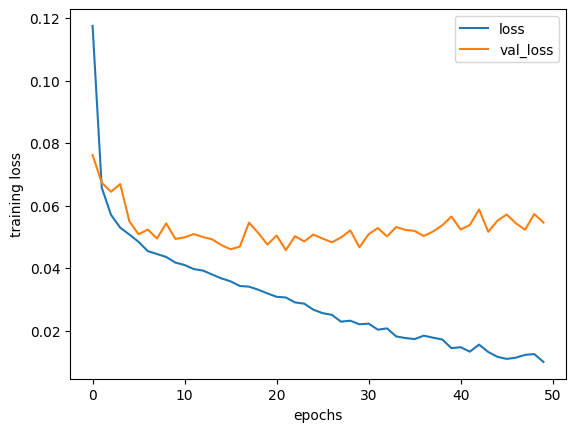

In [114]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.legend()
plt.show()

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:
1- These techniques helped me clean the data and make it easier to understand the data.

2- I added new features such as prev_traffic_volume and the date_time features such as month..etc, it gives me a clear insight of the data to analyze when are the common days to have traffic.

3- I choosed LSTM and GRU for how easily it can be implemnted, I went for a simple architecture at first to see the result luckily I didnt need to make it complex because the result were good.
I find these models appropriate beacuse of its simplicity with the preproccesing and the good predections score.

4- The numbers I choosed was based on practice, I trained the model multiple times to see the result and it was steady.

5- It gives me an insight of the error regression in the predection with the test set.

7 - I just tested the predection with the actual value to say if there is an over or underfitting, luckily the results were good.

8- I would analyze the data more and focus on which features does highly effect the traffic volume, I would try to use algorithms that can predict the future traffic volume to give an insight of the problem.